In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from researchlib.single_import import *

In [4]:
p = builder([
    nn.Linear(10, 512),
    nn.ReLU(),
    nn.Linear(512, 784),
    layer.Reshape((-1, 1, 28, 28))
])

In [42]:
g = builder([
    nn.Linear(110, 8*4*4),
    layer.Reshape((-1, 8, 4, 4)),
    AutoConvTransposeNet2d(8, 3),
    nn.Conv2d(256, 128, 3),
    nn.BatchNorm2d(128),
    nn.ELU(),
    nn.Conv2d(128, 1, 3),
    nn.Sigmoid()
])  

In [63]:
d = builder([
#     layer.ConditionProjection(p),
    AutoConvNet2d(1, 4),
    Auxiliary(builder([
        nn.Linear(512, 10),
        nn.LogSoftmax(-1)
    ])),
    nn.Linear(512, 1),
    nn.Sigmoid(),
])

In [64]:
train_loader = VisionDataset(vision.MNIST, batch_size=32, train=True, normalize=False)

In [65]:
runner = Runner(GANModel(g, d, latent_vector_len=100, condition_vector_len=[10, None], condition_onehot=True), train_loader, None, 'rmsprop', GANLoss('vanilla', aux_loss=F.nll_loss))

In [66]:
runner.init_model('orthogonal')

In [67]:
runner.fit(1)

  Epochs   train_d_loss  train_g_loss 
    1         2.0292        3.5815    


In [68]:
img = runner.model.sample(10, condition_data=range(10))

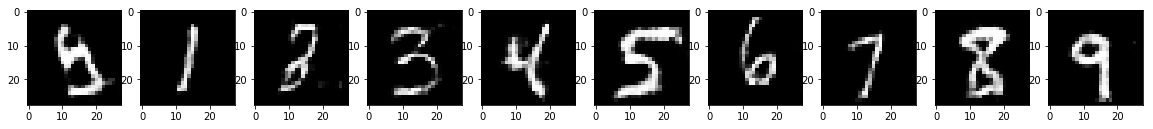

In [69]:
import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    arr[i].imshow(img[i][0].detach().cpu().numpy(), cmap='gray')
plt.show()

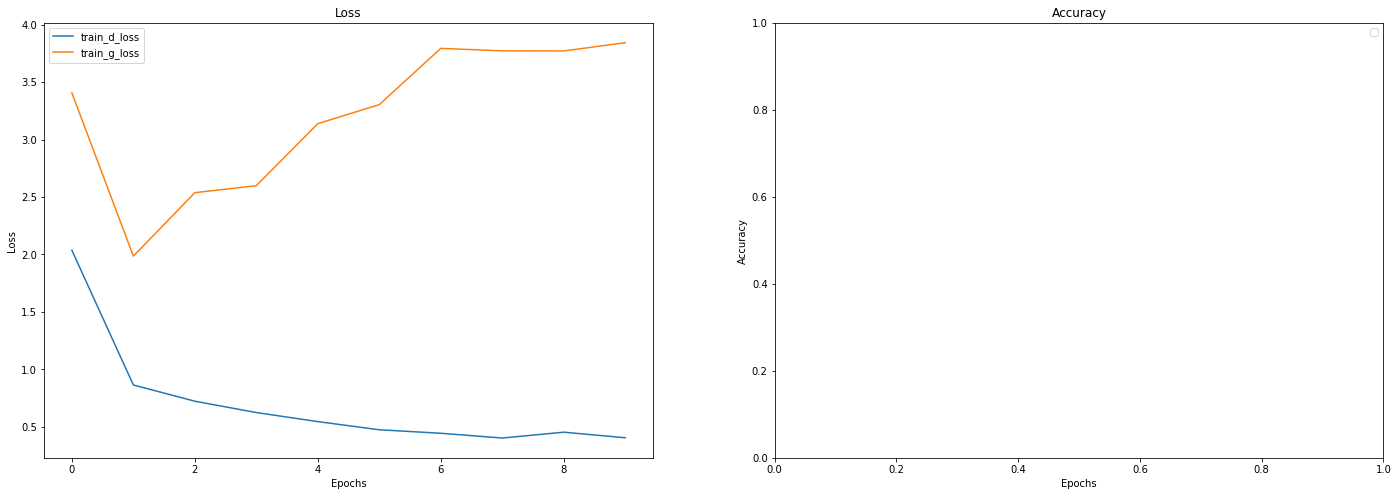

In [22]:
runner.history()